# Consolidated Micro Price Data

Daily prices are obtained for the US, Argentina, Brazil, Colombia, and Chile.

Dates: 2007 to 2010.

Data obtained from the Billion Prices Project. Available at the dataverse page for Online Micro Price Data, https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi%3A10.7910%2FDVN%2FIAH6Z6.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
from scipy.special import factorial
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (8, 6)
matplotlib.style.use('ggplot')

In [2]:
# Define lists of datasets and countries

datasets = ["../Data/usa1.dta","../Data/usa2.dta","../Data/argentina.dta","../Data/brazil.dta","../Data/chile.dta","../Data/colombia.dta"]

country = ["USA Supermarket","USA Department Store","Argentina","Brazil","Chile","Colombia"]

# Load the datasets

for (filename,cntry) in zip(datasets,country):
    data = pd.read_stata(filename)
    print(cntry)
    print(data.head())
    print()
       

USA Supermarket
   id  cat_url  bppcat       date  miss  price0  price  nsprice  sale  \
0   1   1968.0     118 2008-05-08   NaN     2.0    2.0      2.0   NaN   
1   1   1968.0     118 2008-05-09   NaN     2.0    2.0      2.0   NaN   
2   1   1968.0     118 2008-05-10   1.0     NaN    NaN      NaN   NaN   
3   1   1968.0     118 2008-05-11   NaN     2.0    2.0      2.0   NaN   
4   1   1968.0     118 2008-05-12   NaN     2.0    2.0      2.0   NaN   

   fullprice  nsfullprice  fullsale  initialspell  lastspell  category  
0        2.0          2.0       NaN           1.0        NaN     118.0  
1        2.0          2.0       NaN           1.0        NaN     118.0  
2        2.0          2.0       NaN           NaN        NaN     118.0  
3        2.0          2.0       NaN           NaN        NaN     118.0  
4        2.0          2.0       NaN           NaN        NaN     118.0  

USA Department Store
   id  cat_url  bppcat       date  miss  price0      price    nsprice  sale  \
0  75 

In [3]:
# NaN check

for (filename,cntry) in zip(datasets,country):
    data = pd.read_stata(filename)
    print(cntry)
    print("Percentage of NaN in the data:\n")
    print(data.isnull().sum()/len(data))
    print()
    
print("\nWe will use 'nsfullprice' as our price data.")


USA Supermarket
Percentage of NaN in the data:

id              0.000000
cat_url         0.000000
bppcat          0.000000
date            0.000000
miss            0.747364
price0          0.252636
price           0.252636
nsprice         0.252636
sale            0.958572
fullprice       0.014395
nsfullprice     0.014395
fullsale        0.911097
initialspell    0.968245
lastspell       0.959472
category        0.000000
dtype: float64

USA Department Store
Percentage of NaN in the data:

id              0.000000
cat_url         0.000000
bppcat          0.000000
date            0.000000
miss            0.621459
price0          0.378541
price           0.378541
nsprice         0.378541
sale            0.998586
fullprice       0.008994
nsfullprice     0.008994
fullsale        0.994519
initialspell    0.954378
lastspell       0.953015
category        0.000000
dtype: float64

Argentina
Percentage of NaN in the data:

id              0.000000
cat_url         0.000000
bppcat          0.000000


In [4]:
# Function restricts dataset to products that have at least 100 days of data

def at_least_n_days(df, n=100):
    """ Use auxiliary dataset to find id's that have at least n days of data. """
    aux = df.groupby(by='id').count()
    aux = aux[aux['nsfullprice'] > n]
    df = df[df.id.isin(aux.index)]
    return df

# Drop outliers. Definition below, following Cavallo (2018)

def drop_outliers(df):
    df = df[df['log_change'] < 2]  # drop price changes > 200%
    df = df[df['log_change'] > -.7]  # drop price changes < -70%
    return df


In [5]:
# Calculate percentage change of prices

def set_log_change_col(df):
    """ Create price 'log_change' column for each product id. """
    df.sort_values(['id', 'date'], inplace=True)
    gb = df.groupby(['id'])['nsfullprice']
    df['log_change'] = gb.transform(lambda x: np.log(x).diff())
    df.sort_index(inplace=True)
    df = drop_outliers(df)
    return df


In [6]:
# Creates positive/negative/neutral price changes 

def create_directions(df):
    df['Positive'] = np.where(df['log_change'] > 0, df['log_change'], None)
    df['Neutral'] = np.where(df['log_change'] == 0, df['log_change'], None)
    df['Negative'] = np.where(df['log_change'] < 0, df['log_change'], None)
    return df

def basic_numbers(df):
    """ Print number of observations for positive, neutral, and negative price changes. 
    And their respective percentages."""
    pos = df[df['log_change']>0]
    neg = df[df['log_change']<0]
    
    p = len(pos)
    n = len(neg)
    total = len(df['log_change'])
    
    print("Number of positive price changes: ", p)
    print("Number of negative price changes: ", n)  
       
    print("Percentage of positive price changes: ", p/(p+n))
    print("Percentage of negative price changes: ", n/(p+n))
    
    return pos, neg

In [9]:
# Function that carries our data analysis for any given country.

def data_analysis(df, country):
         
    # 1. Set data range.
    
    df['date'] = pd.to_datetime(df['date'])
    
    # 2. Restrict dataset to useful variables. Drop NAs
    
    df = df[["date","id","bppcat","nsfullprice"]]
    df = df.dropna()
      
    # 3. Restrict data to products with at least 100 days of data
    
    df = at_least_n_days(df, n=100)
        
    date_range = df.date.max() - df.date.min()
    n_days = date_range.days
        
    n_products = len(df.id.unique())
    
    print("Initial date: ", df['date'].min())
    print("Final date: ", df['date'].max())
    d = df['date'].max() - df['date'].min()
    print("Total number of days: ", d.days)
    print("Total number of observations: ", len(df))
    print("Number of unique product ids: ", len(df.id.unique()))
    print("Number of individual categories: ", len(df.bppcat.unique()))
    print()
    
    # 4. Add percentage log changes, and directions of price change
    
    daily = set_log_change_col(df)  
    basic_pos, basic_neg = basic_numbers(daily)
            
    # Calculate lambda_plus_mu
    n_pos_chgs = len(basic_pos)
    n_pos_prod = len(basic_pos.id.unique())
    
    # create direction columns
    daily = create_directions(daily)
    daily['pos'] = np.where(daily['Positive']>0,1,0)
    daily['pos'] = daily.groupby('date').pos.transform('sum')
    pos_onedays = len(daily[daily['pos']==1].date.unique())
    pos_days = len(daily[daily['pos']>0].date.unique())
    pos_zerodays = len(daily[daily['pos']==0].date.unique())
    print("Number of days with a positive price change", pos_days)
    print("Number of days with zero price changes ", pos_zerodays)

    # 5. Median log price increase
    
    daily_pos = daily[daily['log_change']>0]
    
    print("n_prods_pos", len(daily_pos.id.unique()))
    stats_pos = daily_pos['log_change'].describe()
    print("Median positive price change: ", daily_pos['log_change'].median())

    # 6. Count how many changes in prices per day
    
    gb_date1 = daily.groupby('date')['Positive', 'Neutral', 'Negative'].count()
    
    # 7. Define avalanches -- conditional on a price change
 
    gb_date1['Positive_shift'] = gb_date1['Positive'].transform(lambda x: x-1)
    
    #Positive price changes only
    gb_date2 = gb_date1[gb_date1['Positive_shift']>-1]
    
    # Positive price changes histogram
    fig, ax1 = plt.subplots(figsize=(7,5))
    ax1.set_title(country)
    ax1.set_xlabel("Number of positive changes in a day (-1)")
    ax1.set_ylabel("Number of days \n with a given number of positive changes")
    ax1.hist(gb_date2['Positive_shift'], bins=100)
    plt.show()
    
    print(gb_date2['Positive_shift'].describe())
    gb_date2 = gb_date2[gb_date2['Positive_shift']<143]
    fig, ax1 = plt.subplots(figsize=(7,5))
    ax1.set_title(country)
    ax1.set_xlabel("Number of positive changes in a day (-1)")
    ax1.set_ylabel("Number of days \n with a given number of positive changes")
    ax1.hist(gb_date2['Positive_shift'], bins=100)
    fig.savefig("../figs/{}_pricechanges.pdf".format(country), bbox_inches='tight')
    plt.show()
    
    # 8. Counter CDF plot
    
    x = np.linspace(1, 142, 142)
    F_x = np.zeros_like(x)

    total = gb_date1['Positive_shift'][gb_date1['Positive_shift']>-1].count()
    for i in range(len(x)):
        F_x[i] = gb_date1['Positive_shift'][gb_date1['Positive_shift'] > x[i]].count() / total
    
    # 9. Fitting a GPD to the counter CDF plot

    def pr(x, a, b):
        pdf = ((a*x + b)**(x-1)) * np.exp(-(a*x + b)) * b / factorial(x)
        pdf0 = (b**(-1)) * np.exp(-b) * b
        ctr_cdf = 1-(np.cumsum(pdf)+pdf0)
        return np.log(ctr_cdf)

    popt, pcov = curve_fit(pr, x, np.log(F_x),bounds=(0,[1,25]))
    print("Normalized RMSE", (np.sqrt(np.mean((F_x-np.exp(pr(x, popt[0],popt[1])))**2)))/np.mean(F_x) )

    print("Optimal values of the parameters:")
    print("theta =", popt[0])
    print("theta0 =", popt[1])
    print("Cov(theta,theta0) = ", pcov)

    # calculate p-value
    test_statistics = popt[0]/pcov[0,0]
    test_p_value = st.norm.cdf(-test_statistics)
    print("p-value for theta: ", test_p_value)

    test_statistics = popt[1]/pcov[1,1]
    test_p_value = st.norm.cdf(-test_statistics)
    print("p-value for theta0: ", test_p_value)
    
    fig, ax = plt.subplots(figsize=(7,5))
    ax.plot(np.log(x), np.log(F_x), label="Data")
    ax.plot(np.log(x), pr(x, popt[0], popt[1]), label="Fit")
    ax.set_ylabel("log(1-F(x))")
    ax.set_xlabel("log(x)")
    ax.legend()
    fig.savefig("../figs/{}_counter.pdf".format(country), bbox_inches='tight')

    # Counter-cumulative data vs fit
    fig, [ax2,ax3] = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    ax2.plot(np.log(x), np.log(F_x), label="Data")
    ax2.plot(np.log(x), pr(x, popt[0], popt[1]), label="Fit")
    ax2.set_ylabel("log(1-F(x))")
    ax2.set_xlabel("log(x)")
    ax2.legend()
    
    
    # Get data restricted to our x
    
    d = gb_date1['Positive_shift'][gb_date1['Positive_shift']>-1]
    quan = d.quantile(0.33)
    quan = quan.item()
    quan = int(quan)
    print("q_j value: ", quan)
    d = d[d<143]
    d = d[d>=quan]
    x = np.linspace(quan, 142, 143 - quan)
    
    # 10. Chi-square goodness-of-fit test for discrete distributions

    # Generate data according to the Generalized Poisson distribution
    def rgpd(x, a, b):
        # a is theta, b is theta0
        px = ((a*x + b)**(x-1)) * np.exp(-(a*x + b)) * b / factorial(x)
        return px

    expected_values = rgpd(x, popt[0], popt[1])
    expected_values = expected_values/expected_values.sum()
    
    gb_date1 = gb_date1[gb_date1['Positive_shift']>=quan]
    number = gb_date1['Positive_shift'][gb_date1['Positive_shift']<143].count()
    expected_values = number*expected_values
    
    
    # Density vs histogram frequency
    aux = ax3.hist(d, bins=len(x), density=False, label="Observed")
    ax3.plot(x,expected_values, label="Expected")
    ax3.legend()
    ax3.set_xlabel("x")
    ax3.set_ylabel("Density")
    extent = ax3.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    # Pad the saved area by 10% in the x-direction and 20% in the y-direction
    plt.tight_layout()
    
    sty = fig.suptitle(country, fontsize="x-large")
    sty.set_y(0.95)
    fig.subplots_adjust(top=0.85)
    fig.savefig("../figs/{}.pdf".format(country), bbox_inches='tight')
    plt.show()
    
    fig, ax4 = plt.subplots(figsize=(7,5))
    ax4.hist(d, bins=len(x), density=False, label="Observed")
    ax4.plot(x,expected_values, label="Expected")
    ax4.legend()
    ax4.set_xlabel("x")
    ax4.set_ylabel("Density")
    fig.savefig("../figs/{}_hist.pdf".format(country), bbox_inches='tight')
    plt.show()
    
    observed_values = aux[0]

    # Chi-square test:
    # H0: data follows GPD 
    # H1: data does not follow GPD
    # hence, our results are good if we do NOT reject the null hypothesis (i.e. p-value>0.05). 

    chi_sq, p_value = chisquare(observed_values, f_exp=expected_values)
    print("p_value for chi-square test: ", p_value)
    
    return popt[0], popt[1], n_days, n_products
    # price median, price median adjusted by pos vs neg, dataset inflation, annual inflation
    # theta, theta0, # days, # products, lambda+mu
   

USA Supermarket
Initial date:  2008-05-08 00:00:00
Final date:  2010-07-31 00:00:00
Total number of days:  814
Total number of observations:  12037687
Number of unique product ids:  21230
Number of individual categories:  26

Number of positive price changes:  91795
Number of negative price changes:  76618
Percentage of positive price changes:  0.5450588731273714
Percentage of negative price changes:  0.4549411268726286
Number of days with a positive price change 712
Number of days with zero price changes  102
n_prods_pos 19609
Median positive price change:  0.17898261547088623


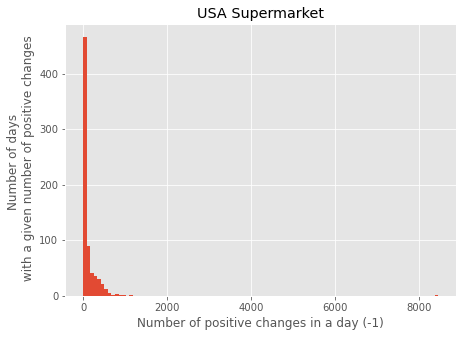

count     712.000000
mean      127.925562
std       352.332751
min         0.000000
25%        18.000000
50%        44.000000
75%       131.500000
max      8453.000000
Name: Positive_shift, dtype: float64


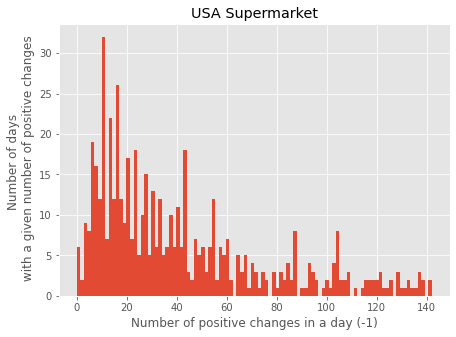

Normalized RMSE 0.0260669791398507
Optimal values of the parameters:
theta = 0.959495937122393
theta0 = 5.65577971577853
Cov(theta,theta0) =  [[ 4.43181243e-07 -1.89817603e-05]
 [-1.89817603e-05  9.11504795e-04]]
p-value for theta:  0.0
p-value for theta0:  0.0
q_j value:  25


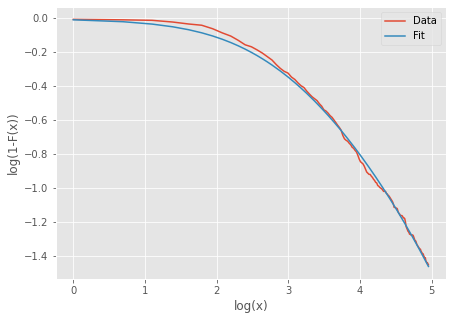

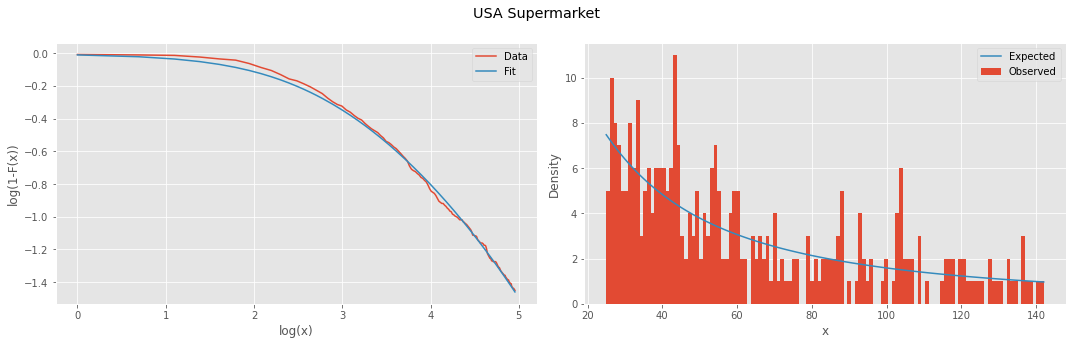

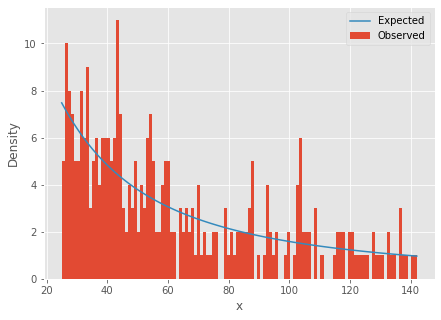

p_value for chi-square test:  0.7832579529160357

USA Department Store
Initial date:  2008-03-18 00:00:00
Final date:  2010-07-31 00:00:00
Total number of days:  865
Total number of observations:  13554672
Number of unique product ids:  50004
Number of individual categories:  32

Number of positive price changes:  24752
Number of negative price changes:  46495
Percentage of positive price changes:  0.3474111190646624
Percentage of negative price changes:  0.6525888809353376
Number of days with a positive price change 688
Number of days with zero price changes  177
n_prods_pos 13514
Median positive price change:  0.1177830696105957


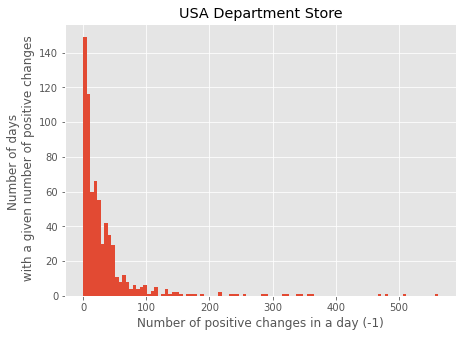

count    688.000000
mean      34.976744
std       60.001111
min        0.000000
25%        7.000000
50%       18.000000
75%       39.000000
max      562.000000
Name: Positive_shift, dtype: float64


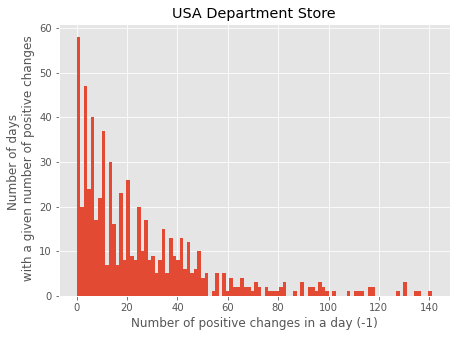

Normalized RMSE 0.10112384521637423
Optimal values of the parameters:
theta = 0.8810071176492742
theta0 = 3.755032700105011
Cov(theta,theta0) =  [[ 1.69951112e-06 -6.68356475e-05]
 [-6.68356475e-05  3.05449193e-03]]
p-value for theta:  0.0
p-value for theta0:  0.0
q_j value:  9


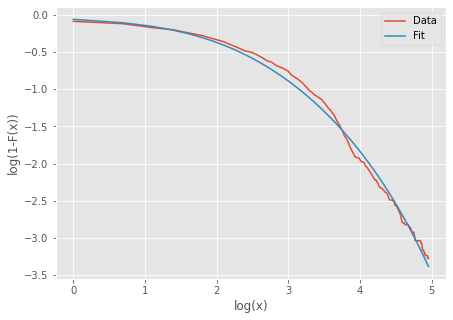

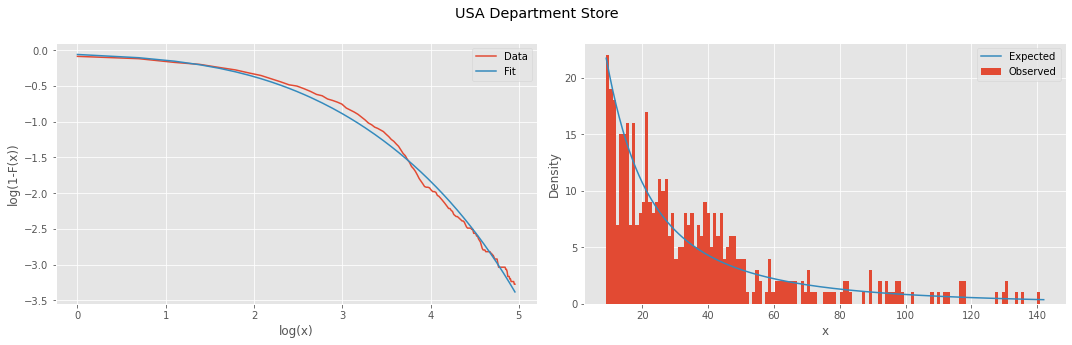

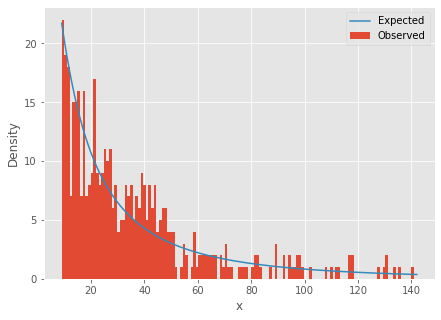

p_value for chi-square test:  0.7169815268816595

Argentina
Initial date:  2007-10-07 00:00:00
Final date:  2010-08-13 00:00:00
Total number of days:  1041
Total number of observations:  15019074
Number of unique product ids:  23506
Number of individual categories:  74

Number of positive price changes:  116241
Number of negative price changes:  27809
Percentage of positive price changes:  0.8069489760499826
Percentage of negative price changes:  0.19305102395001736
Number of days with a positive price change 900
Number of days with zero price changes  141
n_prods_pos 20641
Median positive price change:  0.061557769775390625


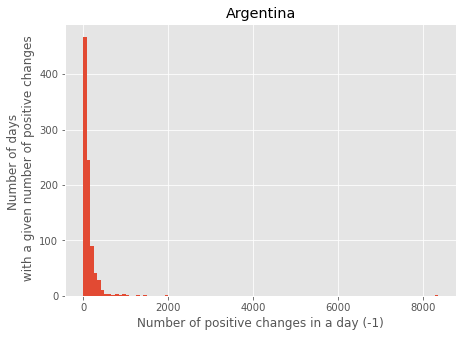

count     900.000000
mean      128.156667
std       314.852892
min         0.000000
25%        30.000000
50%        78.000000
75%       146.250000
max      8358.000000
Name: Positive_shift, dtype: float64


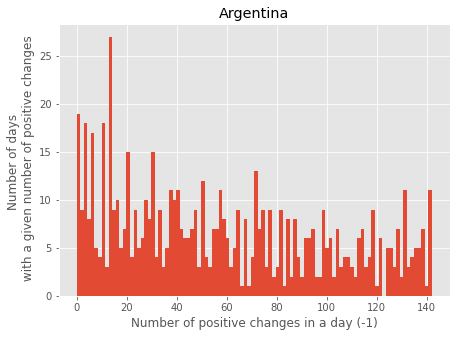

Normalized RMSE 0.04898443603475014
Optimal values of the parameters:
theta = 0.9389954307057988
theta0 = 8.66542867817933
Cov(theta,theta0) =  [[ 3.14589475e-06 -1.88441658e-04]
 [-1.88441658e-04  1.23436795e-02]]
p-value for theta:  0.0
p-value for theta0:  0.0
q_j value:  44


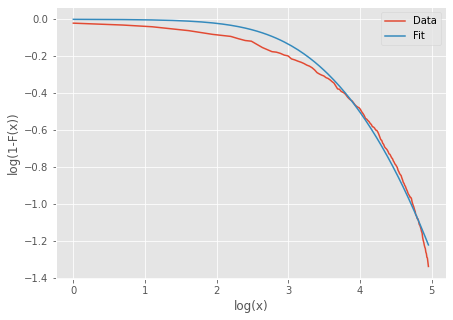

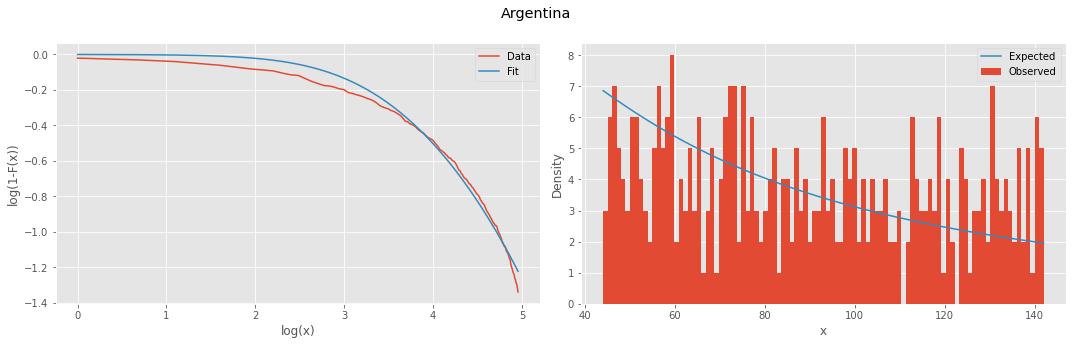

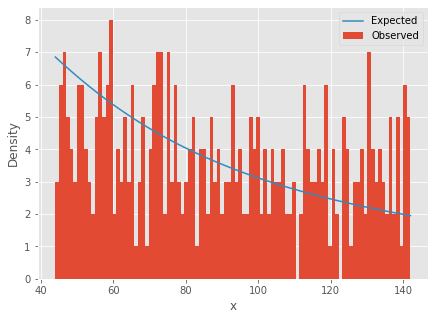

p_value for chi-square test:  0.2711041681394601

Brazil
Initial date:  2007-10-10 00:00:00
Final date:  2010-08-01 00:00:00
Total number of days:  1026
Total number of observations:  12401805
Number of unique product ids:  19933
Number of individual categories:  72

Number of positive price changes:  152580
Number of negative price changes:  102952
Percentage of positive price changes:  0.5971072116212451
Percentage of negative price changes:  0.4028927883787549
Number of days with a positive price change 867
Number of days with zero price changes  159
n_prods_pos 19002
Median positive price change:  0.05190777778625488


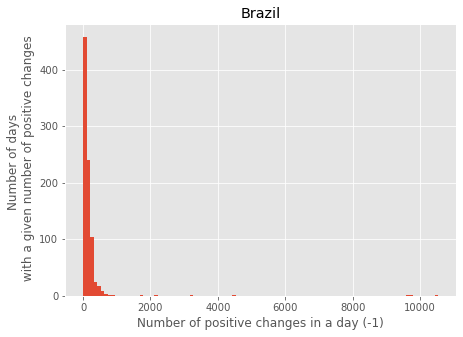

count      867.000000
mean       174.986159
std        625.459380
min          0.000000
25%         41.000000
50%         99.000000
75%        176.500000
max      10538.000000
Name: Positive_shift, dtype: float64


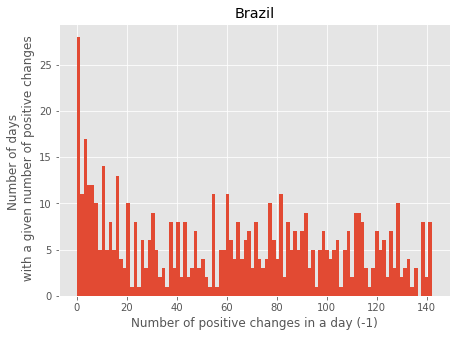

Normalized RMSE 0.06913491757716841
Optimal values of the parameters:
theta = 0.9442129375901298
theta0 = 9.757345584501937
Cov(theta,theta0) =  [[ 8.18275211e-06 -5.22387814e-04]
 [-5.22387814e-04  3.61452712e-02]]
p-value for theta:  0.0
p-value for theta0:  0.0
q_j value:  61


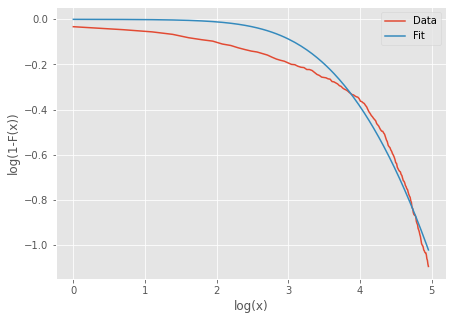

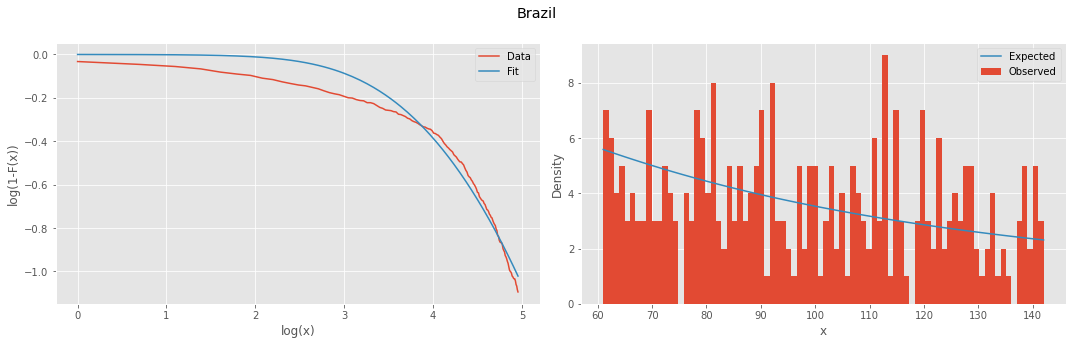

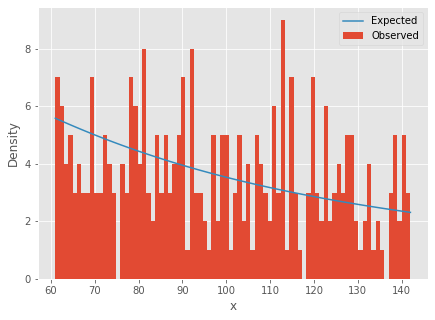

p_value for chi-square test:  0.1573270447388948

Chile
Initial date:  2007-10-24 00:00:00
Final date:  2010-08-13 00:00:00
Total number of days:  1024
Total number of observations:  13651502
Number of unique product ids:  20600
Number of individual categories:  72

Number of positive price changes:  70755
Number of negative price changes:  50096
Percentage of positive price changes:  0.5854730204963137
Percentage of negative price changes:  0.41452697950368633
Number of days with a positive price change 730
Number of days with zero price changes  294
n_prods_pos 16573
Median positive price change:  0.07519674301147461


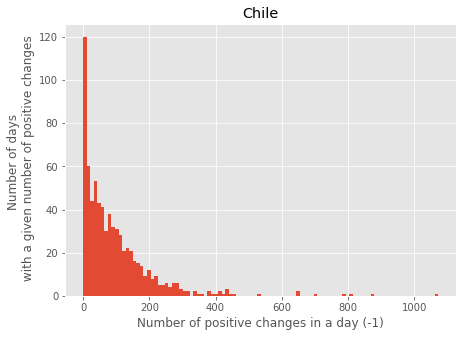

count     730.000000
mean       95.924658
std       111.813943
min         0.000000
25%        22.000000
50%        67.000000
75%       131.750000
max      1072.000000
Name: Positive_shift, dtype: float64


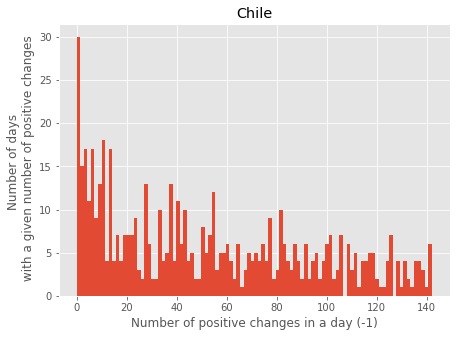

Normalized RMSE 0.07837126295370088
Optimal values of the parameters:
theta = 0.9314354601346388
theta0 = 7.940569921974144
Cov(theta,theta0) =  [[ 4.34915223e-06 -2.50216341e-04]
 [-2.50216341e-04  1.58511949e-02]]
p-value for theta:  0.0
p-value for theta0:  0.0
q_j value:  36


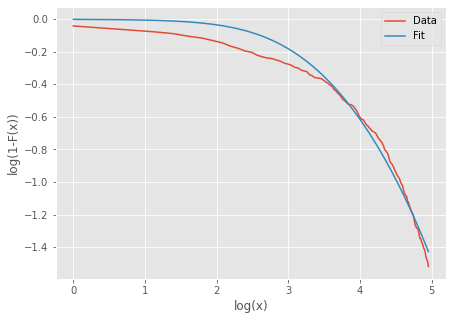

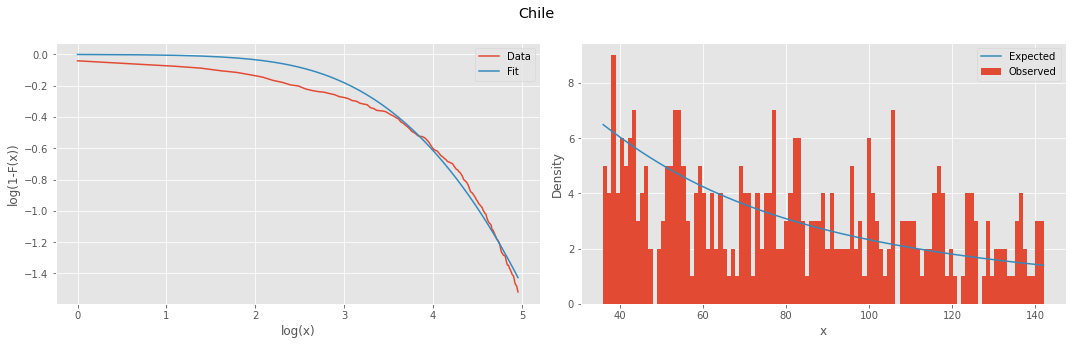

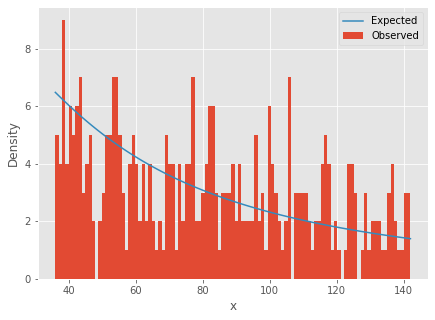

p_value for chi-square test:  0.4144541115999345

Colombia
Initial date:  2007-11-13 00:00:00
Final date:  2010-08-01 00:00:00
Total number of days:  992
Total number of observations:  4737481
Number of unique product ids:  8045
Number of individual categories:  59

Number of positive price changes:  47699
Number of negative price changes:  34508
Percentage of positive price changes:  0.5802303940053767
Percentage of negative price changes:  0.4197696059946233
Number of days with a positive price change 794
Number of days with zero price changes  198
n_prods_pos 7400
Median positive price change:  0.055350303649902344


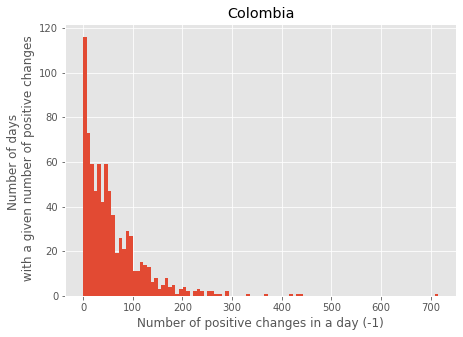

count    794.000000
mean      59.074307
std       63.992814
min        0.000000
25%       16.000000
50%       43.000000
75%       82.000000
max      715.000000
Name: Positive_shift, dtype: float64


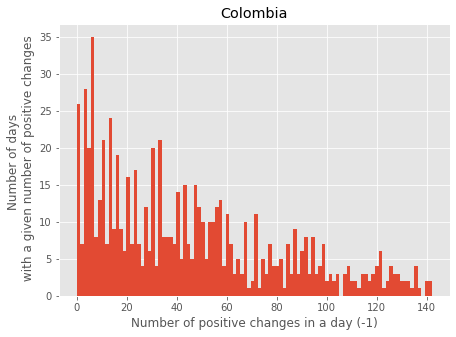

Normalized RMSE 0.09864807582255582
Optimal values of the parameters:
theta = 0.873074861527964
theta0 = 7.770752614639001
Cov(theta,theta0) =  [[ 1.94844753e-06 -1.22203914e-04]
 [-1.22203914e-04  8.49469033e-03]]
p-value for theta:  0.0
p-value for theta0:  0.0
q_j value:  23


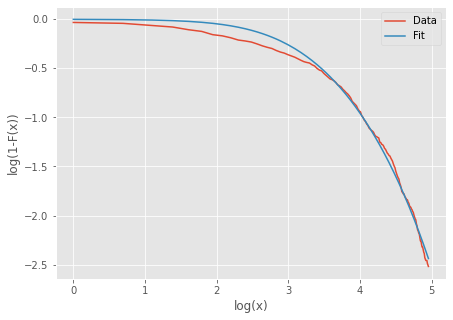

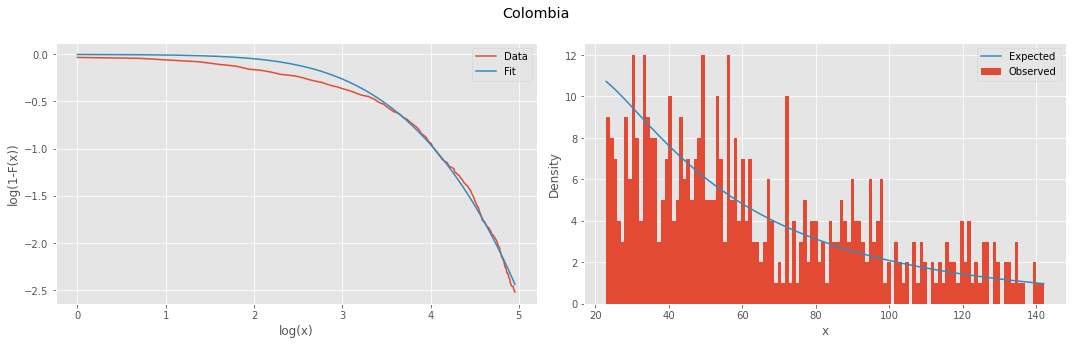

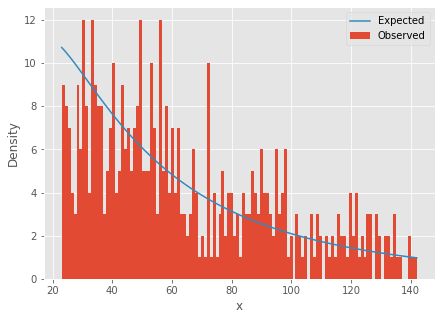

p_value for chi-square test:  0.09102468398286749



In [10]:
import statsmodels.formula.api as sm
df_estimated = pd.DataFrame(columns = ['theta', 'theta0', 
                                       'n_days', 'n_prods'], index = country)
    
for (filename,cntry) in zip(datasets,country):
    data = pd.read_stata(filename)
    print(cntry)
    
    df_estimated.loc[cntry] = data_analysis(data, cntry)
    print()
     